In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy.stats import nbinom, gamma, fisher_exact
from scipy.special import digamma
from scipy.optimize import minimize
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


<h1> Helper Functions </h1>  

In [2]:
def download_faer_files(root_dir):
    # Defines root directory where FAERS datasets are located
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']

    # Adjusts range of files to download (can be 2013 to 2025) 
    all_quarters = [f"{str(y)[2:]}{q}" for y in range(2024, 2025) for q in quarters]

    # Limits to only those quarters that exist (sanity check)
    existing_quarters = [q for q in all_quarters if os.path.exists(os.path.join(root_dir, f"DEMO{q}.txt"))]

    # Stores DataFrames in a dict
    data = {}

    for q in existing_quarters:
        try:
            data[q] = {
                'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'reac': pd.read_csv(os.path.join(root_dir, f"REAC{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'outc': pd.read_csv(os.path.join(root_dir, f"OUTC{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'indi': pd.read_csv(os.path.join(root_dir, f"INDI{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'rpsr': pd.read_csv(os.path.join(root_dir, f"RPSR{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
            }
            print(f"Loaded {q} successfully.")
        except Exception as e:
            print(f"Error loading data for {q}: {e}")
    return data



In [3]:
def generate_periods(start_year, start_quarter, end_year, end_quarter):
    periods = []
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']

    start_year = int(start_year)
    end_year = int(end_year)

    # Loops through the years and quarters to generate all periods in the range
    for year in range(start_year, end_year + 1):
        start_qtr = start_quarter if year == start_year else 'Q1'
        end_qtr = end_quarter if year == end_year else 'Q4'

        for qtr in quarters[quarters.index(start_qtr):quarters.index(end_qtr) + 1]:
            periods.append(f"{str(year)[-2:]}{qtr}")
    return periods


In [4]:
def create_dataframes(start_year, start_quarter, end_year, end_quarter):
    # Generates periods based on user input
    periods = generate_periods(start_year, start_quarter, end_year, end_quarter)
    print(periods)

    # Lists of table types to be processed 
    table_types = ['demo', 'drug', 'reac', 'outc', 'indi', 'rpsr', 'ther']

    # Initializes a dictionary to store lists of DataFrames for each table
    data_dict = {table: [] for table in table_types}

    # Loops through each period and collect data for each table type
    for period in periods:
        if period in data:  # Check if data for the period exists
            for table in table_types:
                if table in data[period]:
                    data_dict[table].append(data[period][table])
        else:
            print(f"Warning: No data available for {period}")

    # Concatenates data for each table type into a single DataFrame
    merged_data = {
        table: pd.concat(data_dict[table], ignore_index=True) if data_dict[table] else pd.DataFrame()
        for table in table_types
    }

    demo = merged_data['demo']
    drug = merged_data['drug']
    reac = merged_data['reac']
    outc = merged_data['outc']
    indi = merged_data['indi']
    rpsr = merged_data['rpsr']
    ther = merged_data['ther']

    return demo, drug, reac, outc, indi, rpsr, ther


In [5]:
def preprocess_drug_df(drug):
    drug = drug[['primaryid', 'caseid', 'role_cod', 'drugname', 'prod_ai', 'drug_seq', 'dechal', 'rechal']]
    
    print("Starting number of reports in 'drug' file: ", drug.shape[0]) 
    
    drug = drug[drug['role_cod'] == 'PS']
    
    print("Number of reports in the 'drug' file where drug is the primary suspect: ", drug.shape[0]) 

    drug = drug[pd.notnull(drug['drugname'])]  # Drops Nulls
    drug = drug[~drug['drugname'].isin(['unknown'])]  # Drops unknowns
    
    print("Number of reports in the 'drug' file after unknown/null drugs are removed: ", drug.shape[0]) 
    
    drug['drugname'] = drug['drugname'].str.strip().str.lower()  # Stips whitespace, Transforms to lowercase
    drug['drugname'] = drug['drugname'].str.replace('\\', '/')  # Standardizes slashes to '/'
    drug['drugname'] = drug['drugname'].map(
        lambda x: x[:-1] if str(x).endswith(".") else x)  # Removes periods at the end of drug names

    drug['prod_ai'] = drug['prod_ai'].str.lower()
    
    return drug


In [6]:
def preprocess_reac_df(reac):
    print("Starting number of reports in 'reac' file: ", reac.shape[0]) 

    reac = reac[pd.notnull(reac['pt'])] # Drops Nulls
    reac = reac[~reac['pt'].isin(['unknown'])]  # Drops unknowns
    
    print("Number of reports in the 'reac' file after unknown/null reacs are removed: ", reac.shape[0]) 

    reac['pt'] = reac['pt'].str.strip().str.lower()  # Transforms to lowercase
    reac['pt'] = reac['pt'].map(
        lambda x: x[:-1] if str(x).endswith(".") else x)  # Removes periods at the end of drug names

    return reac


In [7]:
def preprocess_demo_df(demo):
    print("Starting number of reports in 'demo' file: ", demo.shape[0]) 

    demo = demo[['primaryid', 'caseid', 'caseversion', 'age_cod', 'age', 'sex', 'wt', 'fda_dt', 'event_dt']] 
    
    # If multiple reports have the same primary id and case id, keep the most recent one 
    demo = demo.sort_values(by=['caseid', 'fda_dt', 'primaryid'], ascending=[True, False, False])
    demo = demo.drop_duplicates(subset=['caseid'], keep='first')
    
    print("Number of reports in the 'demo' file after duplicate primary/case id combos are removed: ", demo.shape[0]) 

    demo = demo[pd.notnull(demo['age'])]
    demo = demo[demo.age_cod != 'dec'].reset_index(drop=True)
    demo['age'] = demo['age'].apply(pd.to_numeric, errors='coerce')
    demo['age'] = np.where(demo['age_cod'] == 'MON', demo['age'] * 1 / 12, demo['age'])  # mounth
    demo['age'] = np.where(demo['age_cod'] == 'WK', demo['age'] * 1 / 52, demo['age'])  # week
    demo['age'] = np.where(demo['age_cod'] == 'DY', demo['age'] * 1 / 365, demo['age'])  # day
    demo['age'] = np.where(demo['age_cod'] == 'HR', demo['age'] * 1 / 8760, demo['age'])  # hour
    demo = demo.drop(['age_cod'], axis=1)

    print("Number of reports in the 'demo' file after unknown/invalid ages are removed: ", demo.shape[0]) 


    return demo


In [8]:
def preprocess_ther_df(ther):
    print("Starting number of reports in 'ther' file: ", ther.shape[0]) 

    ther = ther[['primaryid', 'caseid', 'start_dt', 'dsg_drug_seq']] 

    ther = ther.rename(columns={'dsg_drug_seq': 'drug_seq'})

    return ther


In [9]:
def phv_ebgm_qn(theta_hat, N, E):
    r1, b1, r2, b2, p = theta_hat
    prob_f1 = b1 / (b1 + E)
    prob_f2 = b2 / (b2 + E)
    f1_nb = nbinom.pmf(N, n=r1, p=prob_f1)
    f2_nb = nbinom.pmf(N, n=r2, p=prob_f2)
    num = p * f1_nb
    den = num + (1 - p) * f2_nb
    return num / den

def phv_ebgm_score(theta_hat, N, E, qn):
    r1, b1, r2, b2, _ = theta_hat
    e1 = digamma(r1 + N) - np.log(b1 + E)
    e2 = digamma(r2 + N) - np.log(b2 + E)
    exp_log = qn * e1 + (1 - qn) * e2
    eb_log2 = exp_log / np.log(2)
    return 2 ** eb_log2

def phv_ebgm_quant_bisect(cut_point, theta_hat, N, E, qn,
                          digits=2, limits=(-1e5, 1e5), max_iter=2000):
    r1, b1, r2, b2, _ = theta_hat
    lower, upper = limits
    tol = 0.5 * 10 ** (-digits)

    def post_cdf_minus_cp(x):
        c1 = gamma.cdf(x, a=r1 + N, scale=1/(b1 + E))
        c2 = gamma.cdf(x, a=r2 + N, scale=1/(b2 + E))
        return qn * c1 + (1 - qn) * c2 - cut_point

    N = np.asarray(N)
    E = np.asarray(E)
    qn = np.asarray(qn)

    guess = np.ones_like(N, dtype=float)
    err0 = post_cdf_minus_cp(guess)
    is_pos = err0 > 0
    left = np.where(is_pos, lower, guess)
    right = np.where(is_pos, guess, upper)

    for _ in range(max_iter):
        mid = (left + right) / 2
        err_mid = post_cdf_minus_cp(mid)
        if np.max((right - left) / 2) < tol:
            q = np.round(mid, digits)
            if np.any(q == upper):
                raise ValueError("increase maximum for 'limits'")
            return q
        err_left = post_cdf_minus_cp(left)
        same = np.sign(err_left) == np.sign(err_mid)
        left = np.where(same, mid, left)
        right = np.where(same, right, mid)

    raise RuntimeError("failed to converge -- try adjusting 'limits' or 'max_iter'")

def dbinbinom(x, size1, prob1, size2, prob2, w):
    return w * nbinom.pmf(x, n=size1, p=prob1) + (1 - w) * nbinom.pmf(x, n=size2, p=prob2)

def phvid_objective(theta, N, E):
    r1, b1, r2, b2, w = theta
    prob1 = b1 / (b1 + E)
    prob2 = b2 / (b2 + E)
    pmf = dbinbinom(N, r1, prob1, r2, prob2, w)
    return np.sum(-np.log(pmf + 1e-16))  # add tiny epsilon to avoid log(0)

def phv_ebgm(a, b, c, d, alpha=0.05, theta_init=None, squashing=True):
    """
    a, b, c, d: counts (scalars or array‐like)
    alpha: two‐sided significance level
    theta_init: array‐like [r1, b1, r2, b2, p] or pandas.DataFrame of guesses
    squashing: (not implemented – placeholder)
    """
    # turn inputs into arrays
    a, b, c, d = np.broadcast_arrays(a, b, c, d)
    if np.any(a < 0) or np.any(b < 0) or np.any(c < 0) or np.any(d < 0):
        raise ValueError("a, b, c, d must be non‐negative")
    # total counts
    tot = a + b + c + d
    N = a.astype(float)
    E = (a + b) / tot * (a + c)

    # squashing placeholder
    if squashing and np.any(a == 0):
        warnings.warn("squashing=True but no squash implemented; continuing with raw counts")

    # prepare initial guess
    if theta_init is None:
        x0 = np.array([0.2, 0.1, 2.0, 4.0, 1/3])
    else:
        if isinstance(theta_init, pd.DataFrame):
            x0 = theta_init.iloc[0].values
        else:
            x0 = np.asarray(theta_init, dtype=float)
        if x0.shape[0] != 5:
            raise ValueError("theta_init must have length 5")

    # bounds: r1,b1,r2,b2 > 0; p in (0,1)
    bounds = [(1e-6, None)]*4 + [(1e-6, 1-1e-6)]
    res = minimize(phvid_objective, x0, args=(N, E),
                   bounds=bounds, method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("hyperparameter estimation failed: " + res.message)
    theta_hat = res.x

    # compute posterior weights, EBGM and CIs
    qn = phv_ebgm_qn(theta_hat, N, E)
    ebgm = phv_ebgm_score(theta_hat, N, E, qn)
    half = alpha / 2
    ci_low  = phv_ebgm_quant_bisect(half,      theta_hat, N, E, qn)
    ci_high = phv_ebgm_quant_bisect(1 - half,  theta_hat, N, E, qn)

    return pd.DataFrame({
        'ebgm':   ebgm,
        'ci_low': ci_low,
        'ci_high':ci_high
    })

In [10]:
def compute_or_and_ci(a, b, c, d):
    """
    Computes Odds Ratio (OR) and Confidence Interval (CI)
    """
    # Odds Ratio
    or_val = (a * d) / (b * c)

    # Log(OR) and standard error
    log_or = np.log(or_val)
    se = np.sqrt(1 / a + 1 / b + 1 / c + 1 / d)

    # Confidence Interval
    ci_low = np.exp(log_or - 1.96 * se)
    ci_high = np.exp(log_or + 1.96 * se)

    return or_val, ci_low, ci_high


def compute_prr_and_ci(a, b, c, d):
    """ 
    Computes Proportional Reporting Ratio (PRR), Standard Error (SE), and Confidence Interval (CI)
    """ 
    # Proportional Reporting Ratio (PRR)
    prr = (a / (a + b)) / (c / (c + d))

    # Standard Error (SE)
    se = np.sqrt(1 / a + 1 / c - 1 / (a + b) - 1 / (c + d))

    # Confidence Interval for PRR
    ln_prr = np.log(prr)
    ci_low = np.exp(ln_prr - 1.96 * se)
    ci_high = np.exp(ln_prr + 1.96 * se)

    return prr, se, ci_low, ci_high

def compute_bayesian_ic(a, b, c, d,
                        gamma_11=0.5, alpha1=0.5, beta1=0.5, 
                        alpha=2.0, beta=2.0):
    """
    Computes Bayesian Information Component (IC), E(IC), V(IC), and IC-2SD
    based on counts a, b, c, d and prior hyperparameters.
    
    Parameters:
    - a, b, c, d: cell counts (can be arrays) 
    - gamma_11, alpha1, beta1, alpha, beta: prior pseudo-counts (defaults are Jeffrey's prior)
    
    Returns:
    - DataFrame with E(IC), Var(IC), IC_2SD (lower bound)
    """
    # Total N
    N = a + b + c + d
    
    # Compute gamma (normalization term)
    gamma = gamma_11 * ((N + alpha) * (N + beta)) / ((a + b + alpha1) * (a + c + beta1))

    # Expected value of IC (E(IC))
    E_ic = np.log2(
        (a + gamma_11) * (N + alpha) * (N + beta) /
        ((N + gamma) * (a + b + alpha1) * (a + c + beta1))
    )

    # Compute variance of IC (V(IC))
    ln2_sq = np.log(2) ** 2
    term1 = ((N - a + gamma - gamma_11) / ((a + gamma_11) * (1 + N + gamma)))
    term2 = ((N - (a + b) + alpha - alpha1) / ((a + b + alpha1) * (1 + N + alpha)))
    term3 = ((N - (a + c) + beta - beta1) / ((a + c + beta1) * (1 + N + beta)))
    V_ic = (1 / ln2_sq) * (term1 + term2 + term3)

    # Lower bound: IC - 2 * SD
    IC_2SD = E_ic - 2 * np.sqrt(V_ic)

    return pd.DataFrame({
        "E_IC": E_ic,
        "Var_IC": V_ic,
        "IC_2SD": IC_2SD
    })

In [11]:
# Function to add statistics (OR, PRR, EGBM) to the DataFrame
def add_stats(df):
    a = df['Count_query_drug'] 
    b = df['No_AE_query_drug'] 
    c = df['Count_non_query_drug'] 
    d = df['No_AE_non_query_drug'] 

    # Compute Odds Ratio (OR) and Confidence Interval (CI) 
    or_vals, ci_low_or, ci_high_or = compute_or_and_ci(a, b, c, d)

    # Compute Proportional Reporting Ratio (PRR), SE, and Confidence Interval (CI) 
    prr_vals, se_prr, ci_low_prr, ci_high_prr = compute_prr_and_ci(a, b, c, d)

    p_values = []
    for i in range(len(df)):
        # Construct the 2x2 contingency table for the current event
        table = [[a[i], b[i]], [c[i], d[i]]]
        _, p_val_fisher = fisher_exact(table)
        p_values.append(p_val_fisher)

    # Apply Benjamini-Hochberg correction
    _, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')

    # Compute ebgm statistic 
    ebgm_result = phv_ebgm(a, b, c, d, alpha=0.5)

    # Compute ic statistic 
    ic_result = compute_bayesian_ic(a, b, c, d, gamma_11=0.5, alpha1=0.5, beta1=0.5, alpha=2.0, beta=2.0)

    
    # Add new columns for OR, PRR, and p-value statistics
    df['odds_ratio'] = or_vals
    df['ci_lower_or'] = ci_low_or
    df['ci_upper_or'] = ci_high_or
    df['prr'] = prr_vals
    df['se_prr'] = se_prr
    df['ci_lower_prr'] = ci_low_prr
    df['ci_upper_prr'] = ci_high_prr
    df['p_value'] = p_values
    
    df = df.merge(ebgm_result, left_index=True, right_index=True)
    df = df.merge(ic_result, left_index=True, right_index=True)

    print(df)
    return df



<h1>Loading Files and Preprocessing</h1>

In [12]:
root_dir = '/Users/jodie/Documents/BMI 212/faers-cohort-generation/FAERS-data-toolkit-master/FAERSdata'
data = download_faer_files(root_dir)


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_55099/197489246.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 24Q1 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_55099/197489246.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_55099/197489246.py:18: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 24Q2 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_55099/197489246.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 24Q3 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_55099/197489246.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_55099/197489246.py:18: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 24Q4 successfully.


In [13]:
# Get start year/quarter and end year/quarter for querying 
start_year = 2024
start_quarter = 'Q1'
end_year = 2024
end_quarter = 'Q4'

demo, drug, reac, outc, indi, rpsr, ther = create_dataframes(start_year, start_quarter, end_year, end_quarter)


['24Q1', '24Q2', '24Q3', '24Q4']


In [14]:
demo = preprocess_demo_df(demo)
drug = preprocess_drug_df(drug)
reac = preprocess_reac_df(reac)
ther = preprocess_ther_df(ther)

Starting number of reports in 'demo' file:  1619665
Number of reports in the 'demo' file after duplicate primary/case id combos are removed:  1484350
Number of reports in the 'demo' file after unknown/invalid ages are removed:  886012
Starting number of reports in 'drug' file:  7736495
Number of reports in the 'drug' file where drug is the primary suspect:  1647432
Number of reports in the 'drug' file after unknown/null drugs are removed:  1647432
Starting number of reports in 'reac' file:  5794928
Number of reports in the 'reac' file after unknown/null reacs are removed:  5794928
Starting number of reports in 'ther' file:  2228526


<h1>Drug Search, Merging, and Filtering</h1>

In [15]:
# More Configuration 
query_drug = 'edaravone' 
min_age_yrs = 0
max_age_yrs = 100
min_AE_ct = 3 


In [16]:
# Finds reports related to the query drug
query_drug_df = drug[
    drug['drugname'].str.contains(query_drug, na=False) |
    drug['prod_ai'].str.contains(query_drug, na=False)
]

print(f"Number of reports for {query_drug} in 'drug' file/s: ", query_drug_df.shape[0])  

Number of reports for edaravone in 'drug' file/s:  349


In [17]:
# Merges with demo and outc
query_drug_df_merged = pd.merge(demo, query_drug_df, on=['primaryid', 'caseid'], how='inner') # Keep only rows with primaryids in both 'drug' and 'demo'
query_drug_df_merged = pd.merge(query_drug_df_merged, outc, on=['primaryid', 'caseid'], how='left') # Keep existing rows, also append 

print(f"Number of reports for {query_drug} with primary ids in 'drug' and 'demo' files: ", query_drug_df_merged.shape[0])  
print("Number of reports with same 'primaryid': ", query_drug_df_merged.duplicated(subset=['primaryid']).sum())  

Number of reports for edaravone with primary ids in 'drug' and 'demo' files:  128
Number of reports with same 'primaryid':  10


In [18]:
# Filters by age range 
query_drug_df_merged = query_drug_df_merged[
    (query_drug_df_merged['age'] >= min_age_yrs) & 
    (query_drug_df_merged['age'] <= max_age_yrs)
]

print(f"Number of reports for {query_drug} that meet age range of interest: ", query_drug_df_merged.shape[0])
print("Number of reports with same 'primaryid': ", query_drug_df_merged.duplicated(subset=['primaryid']).sum())

Number of reports for edaravone that meet age range of interest:  128
Number of reports with same 'primaryid':  10


<h1> Descriptive Stats (need to add) </h>

In [19]:
# Descriptive stats: Get sex breakdown 
counts = query_drug_df_merged['sex'].value_counts()
percentages = query_drug_df_merged['sex'].value_counts(normalize=True) * 100

summary_df = pd.DataFrame({'count': counts, 'percent': percentages.round(2)})
summary_df

,count,percent
sex,,
M,65,53.72
F,56,46.28


In [38]:
query_drug_df_merged.describe(include='all')


,primaryid,caseid,caseversion,age,sex,wt,fda_dt,event_dt,role_cod,drugname,prod_ai,drug_seq,dechal,rechal,outc_cod
count,1.280000e+02,1.280000e+02,128.000000,128.000000,121,2.000000,1.280000e+02,7.000000e+01,128,128,128,128.000000,90,2,108
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,1,3,1,NaN,4,2,4
top,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,PS,edaravone,edaravone,NaN,D,U,DE
freq,NaN,NaN,NaN,NaN,65,NaN,NaN,NaN,128,67,128,NaN,40,1,45
mean,2.393097e+08,2.393097e+07,1.578125,54.342448,NaN,62.250000,2.024063e+07,2.023654e+07,NaN,NaN,NaN,1.289062,NaN,NaN,NaN
std,4.119650e+06,4.119650e+05,0.828711,26.059662,NaN,1.767767,3.161045e+02,7.116114e+03,NaN,NaN,NaN,1.409486,NaN,NaN,NaN
min,2.270442e+08,2.270442e+07,1.000000,0.166667,NaN,61.000000,2.024010e+07,2.021021e+07,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,2.363162e+08,2.363162e+07,1.000000,48.750000,NaN,61.625000,2.024038e+07,2.023121e+07,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
50%,2.394439e+08,2.394438e+07,1.000000,64.000000,NaN,62.250000,2.024062e+07,2.024040e+07,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
75%,2.420217e+08,2.420217e+07,2.000000,73.000000,NaN,62.875000,2.024090e+07,2.024071e+07,NaN,NaN,NaN,1.000000,NaN,NaN,NaN


<h1> Contingency Table by Preferred Term (pt_name) </h>

In [20]:
# Get AE counts for cases where query drug is mentioned
query_drug_ids = query_drug_df_merged['primaryid'].unique()
query_drug_reac = reac[reac['primaryid'].isin(query_drug_ids)]
ae_counts = query_drug_reac['pt'].value_counts().reset_index()
ae_counts.columns = ['pt_name', 'Count']

# Get AE counts for cases where query drug is not mentioned
non_query_drug = drug[~drug['primaryid'].isin(query_drug_ids)]
non_query_ids = non_query_drug['primaryid'].unique()
non_query_reac = reac[reac['primaryid'].isin(non_query_ids)]
non_ae_counts = non_query_reac['pt'].value_counts().reset_index()
non_ae_counts.columns = ['pt_name', 'Count']

ae_counts.columns = ['pt_name', 'Count_query_drug']
non_ae_counts.columns = ['pt_name', 'Count_non_query_drug']

# Merge AE counts for query drug and non-query drug
ae_comparison = pd.merge(
    ae_counts,
    non_ae_counts,
    on='pt_name',
    how='outer'
)

# Filter to AEs with at least 'min_AE_ct' events for the query drug
ae_filtered = ae_comparison[
    (ae_comparison['Count_query_drug'].notna()) &
    (ae_comparison['Count_query_drug'] >= min_AE_ct)
].copy().reset_index() 

if ae_filtered.empty:
    warnings.warn("Filtered AE dataset is empty — no AEs meet the criteria.", RuntimeWarning)

In [21]:
# Calculates the number of reports that did not include a specific adverse
# event for both the query drug and non-query drugs
query_num = query_drug_ids.shape[0]
non_num = non_query_ids.shape[0]
ae_filtered['No_AE_query_drug'] = query_num - ae_filtered['Count_query_drug']
ae_filtered['No_AE_non_query_drug'] = non_num - ae_filtered['Count_non_query_drug']

In [22]:
ae_filtered

,index,pt_name,Count_query_drug,Count_non_query_drug,No_AE_query_drug,No_AE_non_query_drug
0,671,amyotrophic lateral sclerosis,10.0,157,108.0,1619388
1,1311,asthenia,4.0,34505,114.0,1585040
2,3008,cerebral infarction,3.0,1558,115.0,1617987
3,4145,death,22.0,57858,96.0,1561687
4,4189,dehydration,3.0,9776,115.0,1609769
5,4539,disease progression,4.0,10941,114.0,1608604
6,4796,dysphagia,4.0,7778,114.0,1611767
7,4804,dyspnoea,7.0,48261,111.0,1571284
8,5647,fatigue,3.0,81019,115.0,1538526
9,5993,gait disturbance,5.0,16479,113.0,1603066


In [23]:
ae_filtered_new = add_stats(ae_filtered.copy())

    index                        pt_name  Count_query_drug  \
0     671  amyotrophic lateral sclerosis              10.0   
1    1311                       asthenia               4.0   
2    3008            cerebral infarction               3.0   
3    4145                          death              22.0   
4    4189                    dehydration               3.0   
5    4539            disease progression               4.0   
6    4796                      dysphagia               4.0   
7    4804                       dyspnoea               7.0   
8    5647                        fatigue               3.0   
9    5993               gait disturbance               5.0   
10   6246                    gastrostomy               4.0   
11   6723                       headache               4.0   
12   9120                        malaise               3.0   
13   9312         mechanical ventilation               3.0   
14   9922              muscular weakness               5.0   
15  1016

In [24]:
ae_filtered_new.sort_values(by='p_value')
ae_filtered_new.sort_values(by='Count_query_drug').to_csv(f"pt_terms_{query_drug}.csv", index=False)


In [25]:
ae_filtered_new

,index,pt_name,Count_query_drug,Count_non_query_drug,No_AE_query_drug,No_AE_non_query_drug,odds_ratio,ci_lower_or,ci_upper_or,prr,se_prr,ci_lower_prr,ci_upper_prr,p_value,ebgm,ci_low,ci_high,E_IC,Var_IC,IC_2SD
0,671,amyotrophic lateral sclerosis,10.0,157,108.0,1619388,955.053079,490.429953,1859.850480,874.201123,0.312881,473.458662,1614.137968,9.960731e-27,659.053619,542.26,814.37,4.357384,0.228213,3.401950
1,1311,asthenia,4.0,34505,114.0,1585040,1.611808,0.594672,4.368669,1.591069,0.491481,0.607200,4.169138,3.230655e-01,1.726451,1.32,2.33,0.573073,0.480147,-0.812780
2,3008,cerebral infarction,3.0,1558,115.0,1617987,27.091371,8.600907,85.333144,26.428031,0.570526,8.638199,80.854911,2.195476e-04,13.243507,5.82,33.00,2.510470,0.613571,0.943855
3,4145,death,22.0,57858,96.0,1561687,6.185603,3.891766,9.831443,5.218795,0.192345,3.579669,7.608477,2.216734e-10,4.811791,4.20,5.55,2.248573,0.110102,1.584942
4,4189,dehydration,3.0,9776,115.0,1609769,4.295619,1.364996,13.518238,4.211832,0.570053,1.377946,12.873896,3.518164e-02,3.264199,2.43,4.54,1.525806,0.612450,-0.039378
5,4539,disease progression,4.0,10941,114.0,1608604,5.158783,1.903090,13.984125,5.017807,0.491545,1.914709,13.149986,8.694518e-03,3.760991,2.87,5.07,1.790517,0.480277,0.404476
6,4796,dysphagia,4.0,7778,114.0,1611767,7.270922,2.682071,19.710996,7.058348,0.491583,2.693144,18.498928,2.645792e-03,4.497097,3.42,6.06,2.073134,0.480355,0.686981
7,4804,dyspnoea,7.0,48261,111.0,1571284,2.053210,0.956513,4.407336,1.990732,0.366610,0.970394,4.083920,9.178762e-02,2.029150,1.63,2.58,0.895582,0.295119,-0.190916
8,5647,fatigue,3.0,81019,115.0,1538526,0.495383,0.157439,1.558728,0.508213,0.569974,0.166293,1.553163,2.906249e-01,0.684223,0.51,0.96,-0.876985,0.612263,-2.441929
9,5993,gait disturbance,5.0,16479,113.0,1603066,4.304395,1.757309,10.543286,4.164378,0.437705,1.765909,9.820464,7.398035e-03,3.478283,2.71,4.58,1.688764,0.396118,0.430007


<h1> Contingency Table by SOC Term (using Shlok/May's file) </h>

In [26]:
# Change to reflect path with file associating medra terms with soc terms 
root_dir = '/Users/jodie/Documents/BMI 212/faers-cohort-generation' 
llt_soc = pd.read_csv(os.path.join(root_dir, 'llt_soc.csv'))

In [27]:
llt_soc['pt_name'] = llt_soc['pt_name'].str.lower()
llt_soc

,llt_name,pt_name,hlt_name,hlgt_name,soc_name,soc_abbrev
0,Ventilation pneumonitis,hypersensitivity pneumonitis,Lower respiratory tract inflammatory and immun...,Lower respiratory tract disorders (excl obstru...,"Respiratory, thoracic and mediastinal disorders",Resp
1,11-beta-hydroxylase deficiency,11-beta-hydroxylase deficiency,Inborn errors of steroid synthesis,Metabolic and nutritional disorders congenital,"Congenital, familial and genetic disorders",Cong
2,11-oxysteroid activity incr,oxycorticosteroids increased,Adrenal cortex tests,Endocrine investigations (incl sex hormones),Investigations,Inv
3,11-oxysteroid activity increased,oxycorticosteroids increased,Adrenal cortex tests,Endocrine investigations (incl sex hormones),Investigations,Inv
4,17 ketosteroids urine,17 ketosteroids urine,Reproductive hormone analyses,Endocrine investigations (incl sex hormones),Investigations,Inv
...,...,...,...,...,...,...
89769,Out of specification result not investigated,improper management of out of specification re...,Quality system issues,"Product quality, supply, distribution, manufac...",Product issues,Prod
89770,Missing batch production record,inappropriate batch production records,Quality system issues,"Product quality, supply, distribution, manufac...",Product issues,Prod
89771,Out of specification result invalidated withou...,improper management of out of specification re...,Quality system issues,"Product quality, supply, distribution, manufac...",Product issues,Prod
89772,Out of specification result invalidated withou...,improper management of out of specification re...,Quality system issues,"Product quality, supply, distribution, manufac...",Product issues,Prod


In [28]:
soc_filtered = (
    ae_filtered
    .merge(llt_soc[['pt_name', 'soc_name']], how='left', on='pt_name')
    .groupby('soc_name', as_index=False)
    .agg({
        'Count_query_drug': 'sum',
        'Count_non_query_drug': 'sum',
        'No_AE_query_drug': 'sum',
        'No_AE_non_query_drug': 'sum'
    })
)
soc_filtered

,soc_name,Count_query_drug,Count_non_query_drug,No_AE_query_drug,No_AE_non_query_drug
0,Gastrointestinal disorders,144.0,890370,3042.0,42837345
1,General disorders and administration site cond...,765.0,5132663,13513.0,190832282
2,Infections and infestations,204.0,1428843,5342.0,74689772
3,"Injury, poisoning and procedural complications",72.0,1758156,1344.0,17676384
4,Metabolism and nutrition disorders,24.0,78208,920.0,12878152
5,Musculoskeletal and connective tissue disorders,150.0,316920,3390.0,48269430
6,Nervous system disorders,283.0,2146860,7623.0,106362655
7,"Respiratory, thoracic and mediastinal disorders",286.0,1582122,6086.0,85873308
8,Surgical and medical procedures,57.0,2482,1949.0,27529783


In [29]:
soc_filtered_new = add_stats(soc_filtered.copy())

                                            soc_name  Count_query_drug  \
0                         Gastrointestinal disorders             144.0   
1  General disorders and administration site cond...             765.0   
2                        Infections and infestations             204.0   
3     Injury, poisoning and procedural complications              72.0   
4                 Metabolism and nutrition disorders              24.0   
5    Musculoskeletal and connective tissue disorders             150.0   
6                           Nervous system disorders             283.0   
7    Respiratory, thoracic and mediastinal disorders             286.0   
8                    Surgical and medical procedures              57.0   

   Count_non_query_drug  No_AE_query_drug  No_AE_non_query_drug  odds_ratio  \
0                890370            3042.0              42837345    2.277484   
1               5132663           13513.0             190832282    2.104838   
2               142884

In [30]:
soc_filtered_new

,soc_name,Count_query_drug,Count_non_query_drug,No_AE_query_drug,No_AE_non_query_drug,odds_ratio,ci_lower_or,ci_upper_or,prr,se_prr,ci_lower_prr,ci_upper_prr,p_value,ebgm,ci_low,ci_high,E_IC,Var_IC,IC_2SD
0,Gastrointestinal disorders,144.0,890370,3042.0,42837345,2.277484,1.926883,2.691878,2.219744,0.081435,1.892274,2.603886,9.509256e-18,2.216308,2.09,2.34,1.143965,0.015059,0.898532
1,General disorders and administration site cond...,765.0,5132663,13513.0,190832282,2.104838,1.956958,2.263894,2.045642,0.035176,1.909358,2.191654,1.407242e-72,2.044928,2.00,2.09,1.031409,0.002865,0.924355
2,Infections and infestations,204.0,1428843,5342.0,74689772,1.996195,1.735698,2.295787,1.959551,0.068719,1.712623,2.242083,1.861145e-18,1.957417,1.87,2.05,0.966912,0.010554,0.761443
3,"Injury, poisoning and procedural complications",72.0,1758156,1344.0,17676384,0.538604,0.424911,0.682716,0.562064,0.114818,0.448798,0.703917,3.045334e-08,0.560557,0.52,0.61,-0.827290,0.030179,-1.174731
4,Metabolism and nutrition disorders,24.0,78208,920.0,12878152,4.295619,2.864135,6.442553,4.211832,0.201544,2.837352,6.252144,8.079955e-09,4.171228,3.65,4.81,1.981832,0.087184,1.391295
5,Musculoskeletal and connective tissue disorders,150.0,316920,3390.0,48269430,6.739289,5.722361,7.936936,6.496099,0.079921,5.554216,7.597706,6.514093e-70,6.482784,6.14,6.86,2.672701,0.014424,2.432502
6,Nervous system disorders,283.0,2146860,7623.0,106362655,1.839272,1.633474,2.070998,1.809230,0.058374,1.613633,2.028536,3.354642e-20,1.807802,1.74,1.89,0.853142,0.007606,0.678719
7,"Respiratory, thoracic and mediastinal disorders",286.0,1582122,6086.0,85873308,2.550658,2.265401,2.871835,2.481059,0.057794,2.215346,2.778642,7.813932e-42,2.478947,2.38,2.58,1.306964,0.007593,1.132692
8,Surgical and medical procedures,57.0,2482,1949.0,27529783,324.387438,248.548749,423.366484,315.198463,0.132092,243.301820,408.340846,8.303708e-120,293.240321,268.61,321.15,6.391187,0.038054,6.001036


In [31]:
soc_filtered_new.sort_values(by='Count_query_drug').to_csv(f"soc_terms_{query_drug}.csv", index=False)

<h1> Time-to-Onset Visualizations </h1> 

In [32]:
def prepare_merged_ther_df(ther, query_drug_df_merged, query_drug):
    """
    Merge 'ther' and 'query_drug_df_merged' DataFrames on ['primaryid', 'caseid', 'drug_seq'],
    clean and convert 'start_dt' and 'event_dt' columns to datetime, remove incomplete or invalid dates, 
    and filter rows where event date is before start date.

    Parameters:
        ther (pd.DataFrame): Therapy data
        query_drug_df_merged (pd.DataFrame): Drug data
        query_drug (str): Drug name or label for printing info

    Returns:
        pd.DataFrame: Cleaned merged DataFrame
    """
    # Merge
    merged_df = pd.merge(ther, query_drug_df_merged, on=['primaryid', 'caseid', 'drug_seq'], how='inner')
    print(f"Number of reports for {query_drug} with ids in 'drug', 'demo', and 'ther' files: {merged_df.shape[0]}")

    # Extract and convert start_dt
    start_dt_str = merged_df['start_dt'].astype(str).str.extract(r'(\d{8})')[0]
    merged_df['start_dt'] = pd.to_datetime(start_dt_str, format='%Y%m%d', errors='coerce')
    merged_df = merged_df.dropna(subset=['start_dt'])

    # Extract and convert event_dt
    event_dt_str = merged_df['event_dt'].astype(str).str.extract(r'(\d{8})')[0]
    merged_df['event_dt'] = pd.to_datetime(event_dt_str, format='%Y%m%d', errors='coerce')
    merged_df = merged_df.dropna(subset=['event_dt'])

    print("Number of reports after removal of incomplete dates:", merged_df.shape[0])

    # Remove rows where event_dt is before start_dt
    merged_df = merged_df[merged_df['event_dt'] >= merged_df['start_dt']]
    print("Number of reports after removal of invalid start/event times:", merged_df.shape[0])

    merged_df['time_to_onset'] = (
        merged_df['event_dt'] - merged_df['start_dt']
    ).dt.days
    
    return merged_df

In [33]:
query_drug_df_merged_ther = prepare_merged_ther_df(ther, query_drug_df_merged, query_drug)

Number of reports for edaravone with ids in 'drug', 'demo', and 'ther' files: 53
Number of reports after removal of incomplete dates: 32
Number of reports after removal of invalid start/event times: 30


In [34]:
q1 = query_drug_df_merged_ther['time_to_onset'].quantile(0.25)
q2 = query_drug_df_merged_ther['time_to_onset'].quantile(0.5)
q3 = query_drug_df_merged_ther['time_to_onset'].quantile(0.75)
iqr = q3 - q1

print("Median time to onset in days:", q2)
print("Interquartile Range in days:", iqr)

Median time to onset in days: 15.5
Interquartile Range in days: 29.0


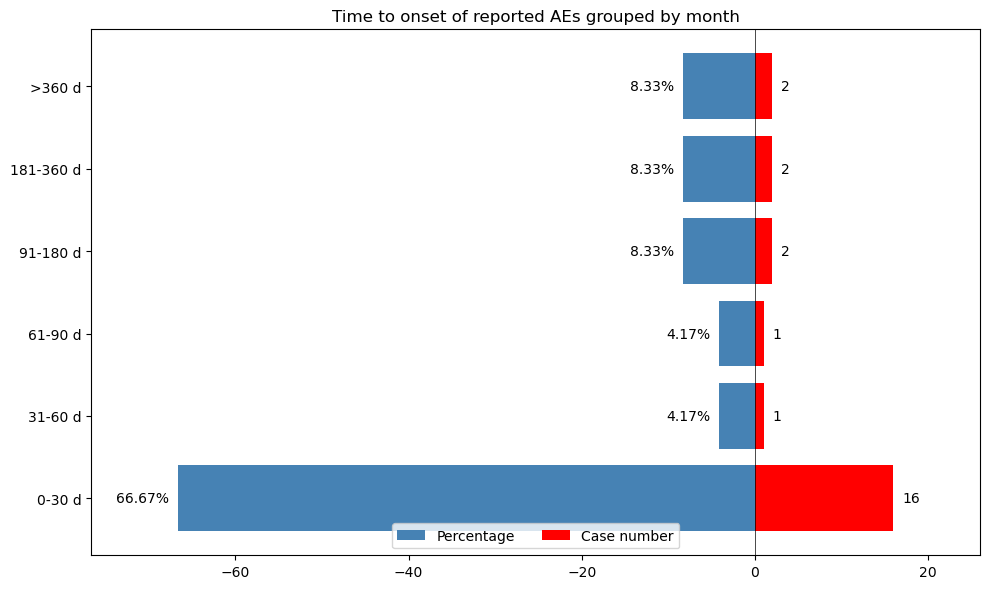

In [35]:
# Define onset bins and labels
bins = [0, 30, 60, 90, 180, 360, float('inf')]
labels = ['0-30 d', '31-60 d', '61-90 d', '91-180 d', '181-360 d', '>360 d']

# Bin the time_to_onset values
query_drug_df_merged_ther['onset_bin'] = pd.cut(
    query_drug_df_merged_ther['time_to_onset'],
    bins=bins,
    labels=labels,
    right=True
)

# Count and percentage
counts = query_drug_df_merged_ther['onset_bin'].value_counts().sort_index()
percentages = (counts / counts.sum() * 100).round(2)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y_pos = range(len(labels))

# Plot percentages to the left (negative values)
ax.barh(y_pos, -percentages, color='steelblue', label='Percentage')

# Plot counts to the right
ax.barh(y_pos, counts, color='red', label='Case number')

# Add text labels
for i, (pct, count) in enumerate(zip(percentages, counts)):
    ax.text(-pct - 1, i, f"{pct}%", va='center', ha='right', color='black')
    ax.text(count + 1, i, str(count), va='center', ha='left', color='black')

# Customize axes
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlim(-max(percentages) - 10, max(counts) + 10)
ax.set_xlabel('')

# Title and legend
ax.set_title('Time to onset of reported AEs grouped by month')
ax.legend(loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

